# Sixt Data Science Lab - Test Task for Data Scientist Job Candidates

## Introduction

In this test task you will have an opportunity to demonstrate your skills of a Data Scientist from various angles - processing data, analyzing and vizalizing it, finding insights, applying predictive techniques and explaining your reasoning about it.

The task is based around a bike sharing dataset openly available at UCI Machine Learning Repository [1].

Please go through the steps below, build up the necessary code and comment on your choices.

# Setup & Imports

In [3]:
import os
import warnings
from pathlib import Path
from urllib.request import urlretrieve
from zipfile import ZipFile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
warnings.filterwarnings('ignore')


## Part 1 - Data Loading and Environment Preparation

**Tasks:**
1. Prepare a Python 3 virtual environment (with virtualenv command). requirements.txt output of pip freeze command should be included as part of your submission.
2. Load the data from UCI Repository and put it into the same folder with the notebook. The link to it is https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset . Here is an available mirror in case the above website is down: https://data.world/uci/bike-sharing-dataset
3. We split the data into two parts. One dataset containing the last 30 days and one dataset with the rest.

# 1-1 Setup & Imports

In [4]:
import os
import warnings
from pathlib import Path
from urllib.request import urlretrieve
from zipfile import ZipFile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
warnings.filterwarnings('ignore')

### 1-2 Loading daily and hourly datasets
Note: split to train and test is moved to later stages.

In [6]:
BASE = Path('.')
PLOTS_DAY = BASE/'plots'/'day'; PLOTS_HOUR = BASE/'plots'/'hour'
PLOTS_DAY.mkdir(parents=True, exist_ok=True) 
PLOTS_HOUR.mkdir(parents=True, exist_ok=True)
DAY_CSV = BASE/'day.csv'
HOUR_CSV = BASE/'hour.csv'
def ensure_data():
    if DAY_CSV.exists() and HOUR_CSV.exists(): return
    try:
        print('Attempting UCI download...')
        url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip'
        zip_path, _ = urlretrieve(url)
        with ZipFile(zip_path, 'r') as zf:
            for name in zf.namelist():
                if name.endswith('day.csv') and not DAY_CSV.exists(): zf.extract(name, BASE); os.replace(BASE/name, DAY_CSV)
                if name.endswith('hour.csv') and not HOUR_CSV.exists(): zf.extract(name, BASE); os.replace(BASE/name, HOUR_CSV)
        print('Download complete.')
    except Exception as e:
        print('Data not found and download failed:', e)
ensure_data()
df_day = pd.read_csv(DAY_CSV)
df_hour = pd.read_csv(HOUR_CSV)
df_day['dteday'] = pd.to_datetime(df_day['dteday'])
df_hour['dteday'] = pd.to_datetime(df_hour['dteday'])
df_day = df_day.sort_values('dteday').reset_index(drop=True)
df_hour = df_hour.sort_values(['dteday','hr']).reset_index(drop=True)
print('Day shape:', df_day.shape, '| Hour shape:', df_hour.shape)

Day shape: (731, 16) | Hour shape: (17379, 17)


## Part 2 - Data Processing and Analysis

**Tasks:**
1. Perform all needed steps to load and clean the data. Please comment the major steps of your code.
2. Visualise rentals of bikes per day.
3. Assume that each bike has exactly maximum 12 rentals per day.
    * Find the maximum number of bicycles `nmax` that was needed in any one day.
    * Find the 95%-percentile of bicycles `n95` that was needed in any one day.
5. Visualize the distribution of the covered days depending on the number of available bicycles (e.g. `nmax` bicycles would cover 100% of days, `n95` covers 95%, etc.)


### 2-1- Data Quality Checks and Missing Values

This section performs **basic data validation** and **missing-value reporting** for both the daily (`df_day`) and hourly (`df_hour`) datasets.

- **Validation checks:**
  - Ensures that the target column `cnt` exists in the daily dataset.
  - Verifies that all values of `cnt` are non-negative (no invalid counts).
  - Prints the overall date range and the number of daily records in the dataset.

- **Missing value analysis:**
  - Computes per-column missing-value counts for both daily and hourly datasets.
  - Displays the results in the notebook.
  - Saves text reports to the `results/analysis/` directory for reference:
    - `missing_day_report.txt` — missing values for daily data  
    - `missing_hour_report.txt` — missing values for hourly data

These checks provide a quick overview of data completeness and help identify potential data quality issues before feature engineering or model training.

In [7]:
assert 'cnt' in df_day.columns, 'Target `cnt` not found.'
assert df_day['cnt'].ge(0).all(), 'Negative counts found (unexpected).'
print('Date range:', df_day['dteday'].min().date(), '-->', df_day['dteday'].max().date())
print('N days:', len(df_day))

# Check for missing values in day data
missing_day = df_day.isnull().sum()

os.makedirs("results/analysis", exist_ok=True)
print("Missing values in day data:\n", missing_day)
# Save missing values report to a text file
with open("results/analysis/missing_day_report.txt", "w") as f:
    f.write(missing_day.to_string())

# Check for missing values in hour data
missing_hour = df_hour.isnull().sum()

print("\nMissing values in hour data:\n", missing_hour)
# Save missing values report to a text file
with open("results/analysis/missing_hour_report.txt", "w") as f:
    f.write(missing_hour.to_string())

Date range: 2011-01-01 --> 2012-12-31
N days: 731
Missing values in day data:
 instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

Missing values in hour data:
 instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


### 2-2 EDA (Daily & Hourly)

This cell creates quick visual checks of target behavior and feature relationships.

- **Daily rentals over time:**  
  Line plot of `cnt` vs. `dteday` (daily data) to inspect long-term trends, seasonality, and outliers.

- **Distribution of `cnt` (daily):**  
  Histogram of daily `cnt` to see skew, spread, and typical demand levels.

- **Seasonal pattern (monthly means):**  
  Average daily `cnt` by calendar month to reveal seasonal peaks/troughs.

- **Weather impact (hourly):**  
  Boxplots of hourly `cnt` grouped by `weathersit` to compare demand under different weather conditions.

- **Diurnal cycle (hourly average):**  
  Line plot of mean `cnt` by hour (0–23) to show morning/evening peaks; figure is also saved to `results/analysis/count_by_hour.png`.

- **Correlation heatmap (hourly):**  
  Correlation matrix between `cnt` and candidate features (`temp`, `atemp`, `hum`, `windspeed`, `weathersit`, `workingday`, `hr`) to highlight linear associations; saved as `results/analysis/correlation_matrix.png`.

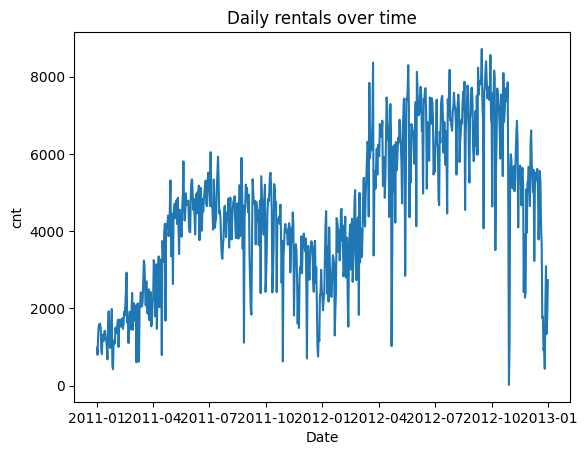

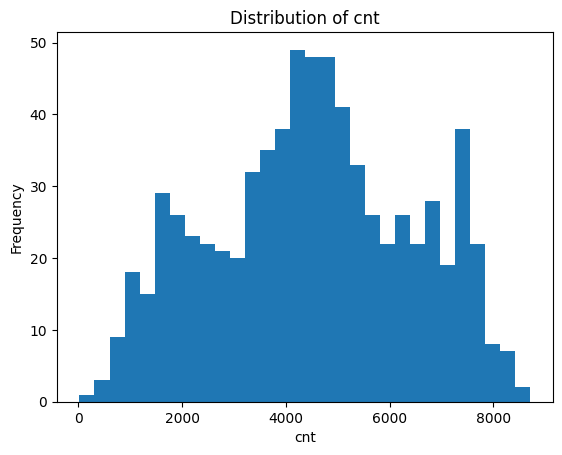

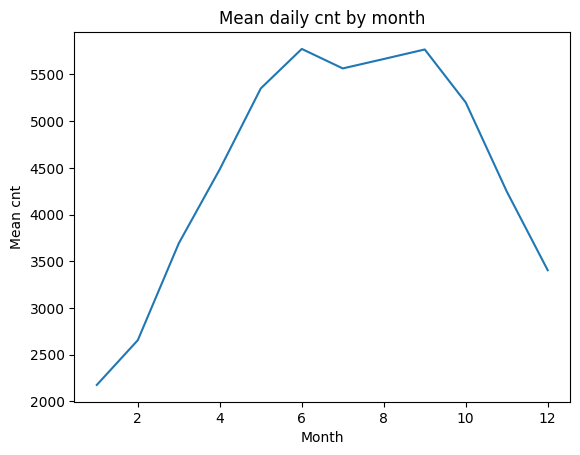

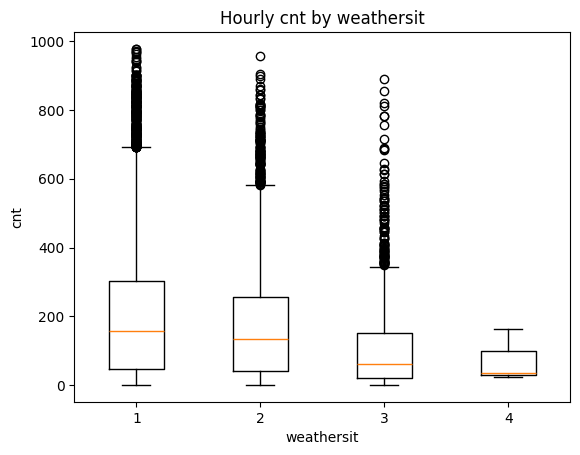

Average cnt by hour:
     hr         cnt
0    0   53.898072
1    1   33.375691
2    2   22.869930
3    3   11.727403
4    4    6.352941
5    5   19.889819
6    6   76.044138
7    7  212.064649
8    8  359.011004
9    9  219.309491
10  10  173.668501
11  11  208.143054
12  12  253.315934
13  13  253.661180
14  14  240.949246
15  15  251.233196
16  16  311.983562
17  17  461.452055
18  18  425.510989
19  19  311.523352
20  20  226.030220
21  21  172.314560
22  22  131.335165
23  23   87.831044


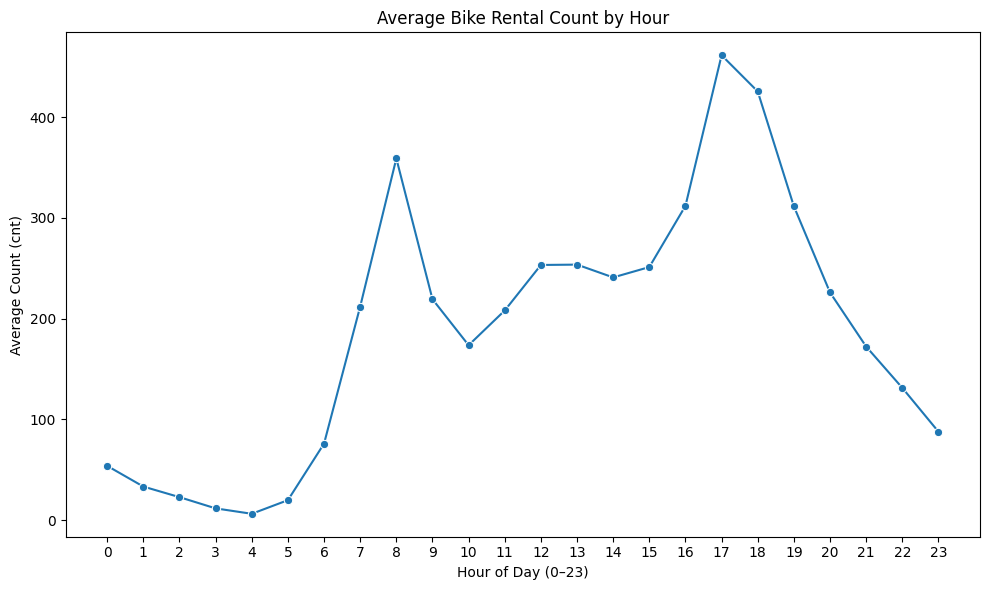

Correlation matrix (day):
                  cnt      temp     atemp       hum  windspeed  weathersit  \
cnt         1.000000  0.404772  0.400929 -0.322911   0.093234   -0.142426   
temp        0.404772  1.000000  0.987672 -0.069881  -0.023125   -0.102640   
atemp       0.400929  0.987672  1.000000 -0.051918  -0.062336   -0.105563   
hum        -0.322911 -0.069881 -0.051918  1.000000  -0.290105    0.418130   
windspeed   0.093234 -0.023125 -0.062336 -0.290105   1.000000    0.026226   
weathersit -0.142426 -0.102640 -0.105563  0.418130   0.026226    1.000000   
workingday  0.030284  0.055390  0.054667  0.015688  -0.011830    0.044672   
hr          0.394071  0.137603  0.133750 -0.276498   0.137252   -0.020203   

            workingday        hr  
cnt           0.030284  0.394071  
temp          0.055390  0.137603  
atemp         0.054667  0.133750  
hum           0.015688 -0.276498  
windspeed    -0.011830  0.137252  
weathersit    0.044672 -0.020203  
workingday    1.000000  0.002285  

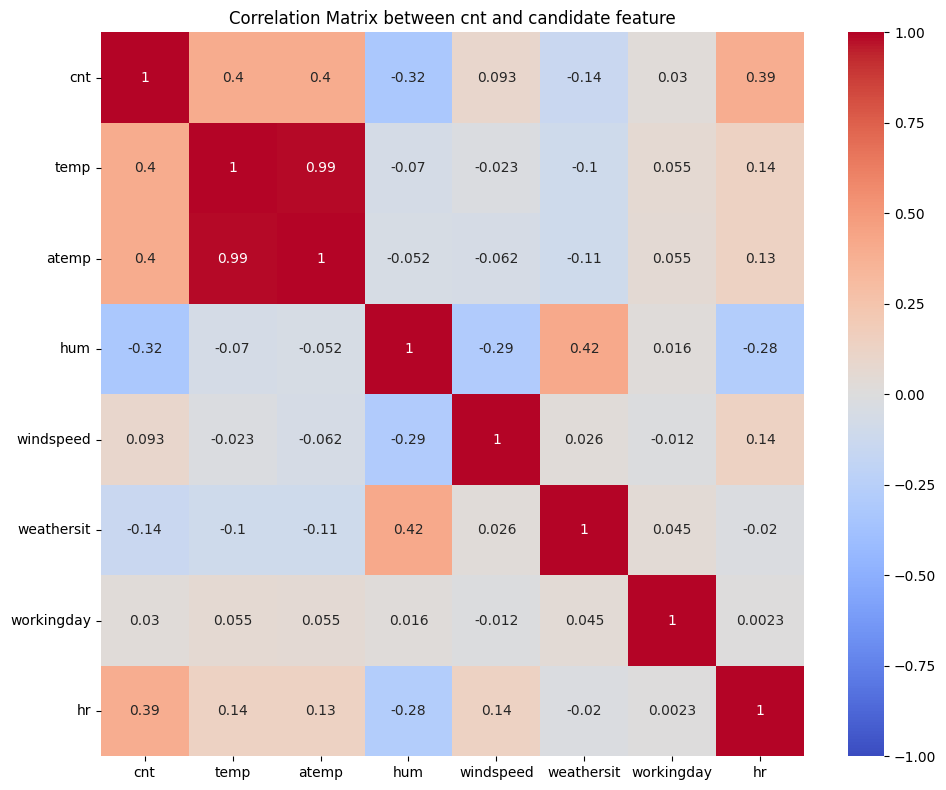

In [8]:
# Target over time
plt.figure()
plt.plot(df_day['dteday'], df_day['cnt'])
plt.title('Daily rentals over time')
plt.xlabel('Date')
plt.ylabel('cnt')
plt.show()

# Simple hist of target
plt.figure()
plt.hist(df_day['cnt'], bins=30)
plt.title('Distribution of cnt')
plt.xlabel('cnt')
plt.ylabel('Frequency')
plt.show()

# Seasonal pattern
plt.figure()
monthly = df_day.groupby(df_day['dteday'].dt.month)['cnt'].mean()
plt.plot(monthly.index, monthly.values)
plt.title('Mean daily cnt by month')
plt.xlabel('Month')
plt.ylabel('Mean cnt')
plt.show()


# Weather situation vs cnt (boxplot style via pure matplotlib)
plt.figure()
data = [df_hour.loc[df_hour['weathersit']==k, 'cnt'] for k in sorted(df_hour['weathersit'].unique())]
plt.boxplot(data, labels=sorted(df_hour['weathersit'].unique()))
plt.title('Hourly cnt by weathersit')
plt.xlabel('weathersit')
plt.ylabel('cnt')
plt.show()

# Plot and save average rental count by hour (0–23)
avg_by_hour = df_hour.groupby('hr', as_index=False)['cnt'].mean().sort_values('hr')
print("Average cnt by hour:\n", avg_by_hour)

plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_by_hour, x='hr', y='cnt', marker='o')
plt.xticks(range(24))
plt.xlabel('Hour of Day (0–23)')
plt.ylabel('Average Count (cnt)')
plt.title('Average Bike Rental Count by Hour')
plt.tight_layout()
plt.savefig('results/analysis/count_by_hour.png')
plt.show()
plt.close()

# Define a list of candidate feature columns
candid_cols = ['temp', 'atemp', 'hum', 'windspeed', 'weathersit', 'workingday', 'hr']

# Compute and print the correlation matrix between cnt and weather features
cols_for_corr_day = ['cnt'] + candid_cols
corr_matrix_day = df_hour[cols_for_corr_day].corr()
print("Correlation matrix (day):\n", corr_matrix_day)

# Plot and save the correlation matrix heatmap
os.makedirs("results/analysis", exist_ok=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_day, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix between cnt and candidate feature')
plt.tight_layout()
plt.savefig('results/analysis/correlation_matrix.png')
plt.show()
plt.close()

### 2-3 Fleet Sizing from Demand (12 rentals per bike per day)

This cell estimates how many bicycles are needed to meet daily demand under a simple capacity rule:

- **Assumption:** Each bike can be rented at most **12 times per day**.
- For each day, compute **`bikes_needed = ceil(cnt / 12)`**.
- Report:
  - **`nmax`** — the **maximum** bikes required on any day (covers 100% of days).
  - **`n95`** — the **95th-percentile** bikes required (covers at least 95% of days).

These metrics help size the fleet for worst-case vs. typical high-demand days.


In [9]:
os.makedirs("results/analysis", exist_ok=True)

MAX_RENTS_PER_BIKE_PER_DAY = 12

# Work on daily data
dfd = df_day.sort_values("dteday").copy()
dfd["bikes_needed"] = np.ceil(dfd["cnt"] / MAX_RENTS_PER_BIKE_PER_DAY).astype(int)

# nmax (max bikes needed on any day)
nmax = int(dfd["bikes_needed"].max())

# n95 (95th percentile bikes needed) – minimal integer covering ≥95% of days
n95 = int(np.quantile(dfd["bikes_needed"], 0.95, method="higher"))

print(f"nmax (max bikes needed on any day): {nmax}")
print(f"n95 (95th-percentile bikes needed): {n95}")



nmax (max bikes needed on any day): 727
n95 (95th-percentile bikes needed): 632


### 2-4 Coverage Curve (Days Covered vs Available Bicycles)

This cell quantifies **service coverage** as a function of fleet size:

- For each candidate fleet size `n` (from 1 up to `nmax`), compute the **percentage of days** where daily demand can be met:
  \[
  \text{% covered}(n) = \frac{\#\{\text{days with } \text{bikes\_needed} \le n\}}{\text{total days}} \times 100
  \]
- Store results in `coverage_df` and save as `bike_coverage_curve.csv`.
- Plot the **coverage curve** (x: available bikes, y: % days covered), with reference lines for:
  - **`n95`** (vertical dashed line) — 95% coverage,
  - **95%** (horizontal dotted line),
  - **`nmax`** (vertical dashed line) — 100% coverage.

This visualization shows how increasing fleet size improves the share of days where demand is fully satisfied under the **12 rentals/bike/day** assumption.


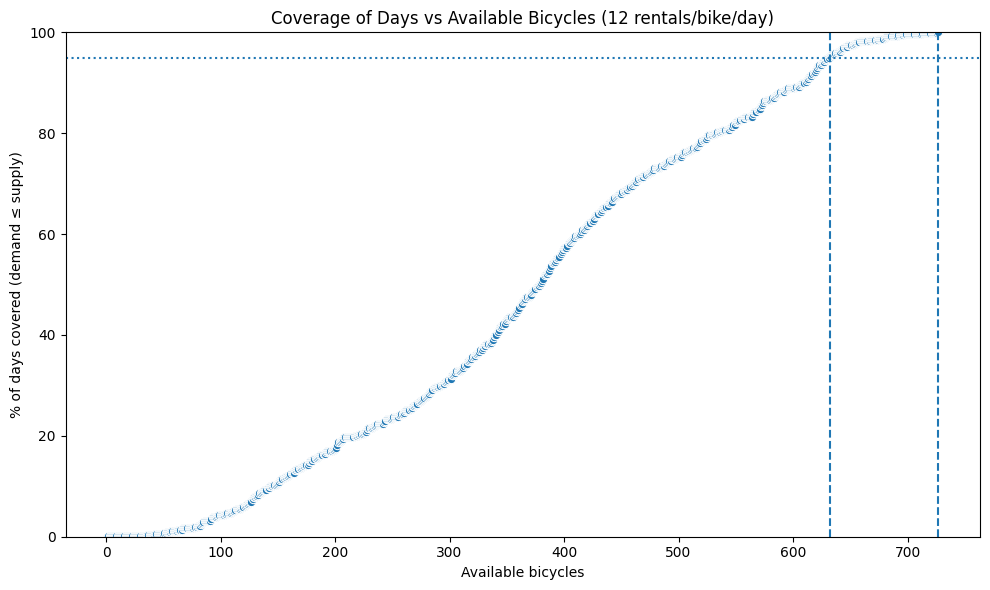

In [10]:
# Coverage curve: for each available bike count n, what % of days are covered?
n_vals = np.arange(1, nmax + 1)
coverage = (dfd["bikes_needed"].to_numpy()[None, :] <= n_vals[:, None]).mean(axis=1) * 100.0
coverage_df = pd.DataFrame({"bikes_available": n_vals, "pct_days_covered": coverage})
coverage_df.to_csv("results/analysis/bike_coverage_curve.csv", index=False)

# Plot coverage vs available bikes
plt.figure(figsize=(10, 6))
sns.lineplot(data=coverage_df, x="bikes_available", y="pct_days_covered", marker="o")
plt.axvline(n95, linestyle="--")
plt.axhline(95, linestyle=":")
plt.axvline(nmax, linestyle="--")
plt.ylim(0, 100)
plt.xlabel("Available bicycles")
plt.ylabel("% of days covered (demand ≤ supply)")
plt.title("Coverage of Days vs Available Bicycles (12 rentals/bike/day)")
plt.tight_layout()
plt.savefig("results/analysis/bike_coverage_curve.png")
plt.show()
plt.close()

## Part 3 - Building prediction models

**Tasks:**
1. Define a test metric for predicting the daily demand for bike sharing, which you would like to use to measure the accuracy of the constructed models, and explain your choice.
2. Build a demand prediction model with Random Forest, preferably making use of following python libraries: scikit-learn. 
3. Report the value of the chosen test metric on the provided data. 

### 3-1 Choice of Evaluation Metric for Daily Demand Prediction

To evaluate model accuracy for daily bike‐rental demand, several metrics were considered — **RMSE**, **MAE**, **MAPE**, and **R²**.

- **Root Mean Squared Error (RMSE)**  
  RMSE measures the average magnitude of prediction errors in the same units as the target (number of rentals).  
  It penalizes large errors more strongly than small ones, making it a good choice when large under/overestimates are especially undesirable.  
  Because daily bike demand can vary substantially (e.g., due to weather or events), RMSE captures how well the model tracks both normal and peak periods.

- **Mean Absolute Error (MAE)**  
  Complements RMSE by measuring typical absolute deviation without heavy penalty for outliers.

- **Mean Absolute Percentage Error (MAPE)**  
  Provides a scale‐free sense of average percentage error, though it can be unstable for very small counts.

- **R² (Coefficient of Determination)**  
  Measures how much of the variance in daily demand is explained by the model.

**Chosen primary metric:**  
RMSE is selected as the main accuracy metric for daily demand forecasting.  
It directly reflects prediction quality in real rental‐count units, emphasizes large errors that affect operational planning (e.g., bike shortages), and remains interpretable for capacity management decisions.


### 3-2-1 Feature Engineering and Data Splitting

This section creates additional time‐based and nonlinear features for both **daily** (`df_day`) and **hourly** (`df_hour`) datasets, and splits them into training/validation and test sets.

#### 1. Feature Engineering Functions
- **`fe_day(df)`** — Adds daily features:
  - Calendar variables: day of week (`dow`), ISO week number (`weekofyear`).
  - Lag features: previous day (`cnt_lag1`) and previous week (`cnt_lag7`) demand.
  - Rolling statistics: 7‐day rolling mean (`cnt_roll7_mean`) and standard deviation (`cnt_roll7_std`) of demand.
  - Nonlinear terms: squared values of temperature, humidity, and wind speed to capture curved effects.
  - Drops rows with missing values created by lag/rolling operations.

- **`fe_hour(df)`** — Adds hourly features:
  - Calendar variables: day of week (`dow`) and cyclic encodings of hour (`hr_sin`, `hr_cos`) to represent the 24‐hour cycle smoothly.
  - Lag features: previous hour (`cnt_lag1`), previous day (`cnt_lag24`), and previous week (`cnt_lag168`).
  - Rolling statistics: 24‐hour and 168‐hour rolling means and standard deviations.
  - Nonlinear terms: squared values of weather variables (`temp2`, `hum2`, `windspeed2`).
  - Drops rows with missing lag/rolling values.

#### 2. Feature Set Selection Functions
- **`get_feature_cols_ls`** — Selects columns for **linear models (e.g., Ridge)** by excluding target and leakage variables (`cnt`, `casual`, `registered`, etc.).
- **`get_feature_cols_gb`** — Selects columns for **tree‐based models** (LightGBM, XGBoost) by dropping exact identifiers and suffixes related to squared or cyclic terms (`_2`, `_sin`, `_cos`).
- **`get_feature_cols_lstm`** — Selects features for **LSTM models**, removing leakage features (`cnt_lag*`, `cnt_roll*`) and static identifiers, since LSTMs already use sequential context.

#### 3. Train/Test Split
- Defines the **last 30 days** as the test period for both datasets.
- Uses all earlier data for **training/validation**.
- Prints the resulting shapes for the split datasets.

This setup prepares consistent, leak‐free features tailored to each model type and ensures fair temporal evaluation on the most recent 30‐day holdout.


In [ ]:
def fe_day(df):
    df = df.copy()
    # Calendar
    df['dow']=df['dteday'].dt.dayofweek
    df['weekofyear']=df['dteday'].dt.isocalendar().week.astype(int)
    # Lags
    for lag in [1,7]: 
        df[f'cnt_lag{lag}']=df['cnt'].shift(lag)
    # Rolling
    df['cnt_roll7_mean']=df['cnt'].rolling(7).mean()
    df['cnt_roll7_std']=df['cnt'].rolling(7).std()
    # Interaction-ish nonlinearities
    df['temp2']=df['temp']**2
    df['hum2']=df['hum']**2
    df['windspeed2']=df['windspeed']**2
    # Drop rows with NaNs introduced by lags/rolling
    return df.dropna().reset_index(drop=True)
def fe_hour(df):
    df=df.copy()
    # Calendar
    df['dow']=df['dteday'].dt.dayofweek
    hr=df['hr'].astype(float)
    import numpy as np
    # Lags
    df['hr_sin']=np.sin(2*np.pi*hr/24)
    df['hr_cos']=np.cos(2*np.pi*hr/24)
    for lag in [1,24,168]: 
        df[f'cnt_lag{lag}']=df['cnt'].shift(lag)
    # Rolling
    df['cnt_roll24_mean']=df['cnt'].rolling(24).mean()
    df['cnt_roll24_std']=df['cnt'].rolling(24).std()
    df['cnt_roll168_mean']=df['cnt'].rolling(168).mean()
    df['cnt_roll168_std']=df['cnt'].rolling(168).std()
    # Adding nonlinearities to help linear models
    df['temp2']=df['temp']**2
    df['hum2']=df['hum']**2
    df['windspeed2']=df['windspeed']**2
    # Drop rows with NaNs introduced by lags/rolling
    return df.dropna().reset_index(drop=True)

# Feature set used for learning a linear model (ridge)
def get_feature_cols_ls(df):
    return [c for c in df.columns if c not in ['cnt','dteday','instant','casual','registered', 'registered', 'yr']]

# Feature set used for learning tree-based models (lgbm & xgboost)
def get_feature_cols_gb(df):
    # Exact columns to drop
    drop_exact = {'cnt', 'dteday', 'instant', 'casual', 'registered', 'yr'}

    # Any column whose name ends with one of these will be removed
    drop_suffixes = ('2', 'sin', 'cos')

    cols = []
    for c in df.columns:
        if c in drop_exact:
            continue
        if c.endswith(drop_suffixes):  
            continue
        cols.append(c)
    return cols

# Feature set used for learning lstm model
def get_feature_cols_lstm(df):
    # Exact columns to drop
    drop_exact = {'dteday', 'instant', 'casual', 'registered', 'yr'} # No leakage since window only contains past history

    # Any column whose name starts with one of these will be removed
    drop_prefixes = ('cnt_lag', 'cnt_roll')
    # Any column whose name ends with one of these will be removed
    drop_suffixes = ('2', 'sin', 'cos')
    cols = []
    for c in df.columns:
        if c in drop_exact:
            continue
        if c.startswith(drop_prefixes):   
            continue
        if c.endswith(drop_suffixes):  
            continue
        cols.append(c)
    return cols

df_aug_day = fe_day(df_day)

# Identify last 30 days in the original timeline
last_30_start_date = df_day['dteday'].max() - pd.Timedelta(days=29)


mask_test_day = df_aug_day['dteday'] >= last_30_start_date
df_trainval_day = df_aug_day.loc[~mask_test_day].copy()
df_test_day = df_aug_day.loc[mask_test_day].copy()

print('Train/Val size using day.csv:', df_trainval_day.shape, '| Test size:', df_test_day.shape)


df_aug_hour = fe_hour(df_hour)


mask_test_hour = df_aug_hour['dteday'] >= last_30_start_date
df_trainval_hour = df_aug_hour.loc[~mask_test_hour].copy()
df_test_hour = df_aug_hour.loc[mask_test_hour].copy()

print('Train/Val size using hour.csv:', df_trainval_hour.shape, '| Test size:', df_test_hour.shape)

Train/Val size using day.csv: (694, 25) | Test size: (30, 25)
Train/Val size using hour.csv: (16493, 30) | Test size: (718, 30)


### 3-2-2 Training Linear Model (Daily Data)

This block builds a **leak-free sklearn pipeline** for daily demand prediction with **Ridge regression**, evaluates it with **time-series cross-validation**, then trains on all train/val data and assesses on the test set.

- **Feature prep**
  - Split features into **numeric** and **categorical**.
  - Apply a `ColumnTransformer`:
    - `StandardScaler` to numeric columns (puts features on comparable scales for Ridge’s L2 penalty).
    - `OneHotEncoder(handle_unknown='ignore')` to categorical columns (stable encoding across train/test).

- **Model & CV**
  - `Ridge(alpha=10.0)` inside a `Pipeline([('prep', ...), ('model', ...)])` so preprocessing is **fit only on the training fold** (prevents leakage).
  - `TimeSeriesSplit(n_splits=2)` for **forward-chaining** CV that respects temporal order.
  - `cross_val_score(..., scoring='neg_root_mean_squared_error')` yields negative RMSE per fold; we print **positive RMSEs** for readability.

- **Train & test**
  - Refit the pipeline on **all train/val** data.
  - Predict on the **held-out last-30-day** test set.
  - Report **RMSE, MAE, R², MAPE\*** (simple scale-aware and scale-free diagnostics).

- **Visualization**
  - Plot **Actual vs Predicted** `cnt` across the test period to visually inspect tracking and bias.


In [ ]:
X_cols_day = get_feature_cols_ls(df_trainval_day)
y_col_day = 'cnt'

numeric_features_day = df_trainval_day[X_cols_day].select_dtypes(include=[np.number]).columns.tolist()
categorical_features_day = [c for c in df_trainval_day[X_cols_day].columns if c not in numeric_features_day]

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_day),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_day)
    ]
)

ridge_model_day = Ridge(alpha=10.0, random_state=42)
cv_results = {}
pipe = Pipeline(steps=[('prep', preprocess), ('model', ridge_model_day)])
tscv = TimeSeriesSplit(n_splits=2)
scores = cross_val_score(pipe,
                            df_trainval_day[X_cols_day], df_trainval_day[y_col_day],
                            scoring='neg_root_mean_squared_error',
                            cv=tscv,
                            n_jobs=None)
cv_results['ridge_day'] = -scores  # make positive
print('ridge_day', 'CV RMSE:', np.round(-scores, 2))

#Train the pipeline on all trainval data
pipe.fit(df_trainval_day[X_cols_day], df_trainval_day[y_col_day])

# Assess performance over test data
y_hat = pipe.predict(df_test_day[X_cols_day])
y_true = df_test_day[y_col_day].values

def metrics(y, y_pred):
    rmse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    mape = np.mean(np.abs((y - y_pred) / np.maximum(1, np.abs(y)))) * 100.0
    return rmse, mae, r2, mape

rmse, mae, r2, mape = metrics(y_true, y_hat)
print(f'Test RMSE: {rmse:.2f}\nTest MAE: {mae:.2f}\nTest R^2: {r2:.3f}\nTest MAPE*: {mape:.2f}%')
res = df_test_day[['dteday','cnt']].copy()
res['pred'] = y_hat
res.head()

import matplotlib.pyplot as plt

plt.figure()
plt.plot(res['dteday'], res['cnt'], label='actual')
plt.plot(res['dteday'], res['pred'], label='pred')
plt.title('Last-30-Day Holdout: Actual vs Predicted cnt using linear model')
plt.xlabel('Date')
plt.ylabel('cnt')
plt.legend()
plt.show()

### 3-2-3 Training Linear Model (Hourly Data)

In [ ]:
X_cols_hour = get_feature_cols_ls(df_trainval_hour)
y_col_hour = 'cnt'

numeric_features_hour = df_trainval_hour[X_cols_hour].select_dtypes(include=[np.number]).columns.tolist()
categorical_features_hour = [c for c in df_trainval_hour[X_cols_hour].columns if c not in numeric_features_hour]

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_hour),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_hour)
    ]
)

ridge_model_hour = Ridge(alpha=10.0, random_state=42)
pipe = Pipeline(steps=[('prep', preprocess), ('model', ridge_model_hour)])

tscv = TimeSeriesSplit(n_splits=2)
scores = cross_val_score(pipe,
                            df_trainval_hour[X_cols_hour], df_trainval_hour[y_col_hour],
                            scoring='neg_root_mean_squared_error',
                            cv=tscv,
                            n_jobs=None)
cv_results['ridge_hour'] = -scores  # make positive
print('ridge_hour', 'CV RMSE:', np.round(-scores, 2))

#Train the pipeline on all trainval data
pipe.fit(df_trainval_hour[X_cols_hour], df_trainval_hour[y_col_hour])

#
y_col_hour = 'cnt'
os.makedirs("results/analysis", exist_ok=True)

# Ensure datetime dtype
df_test_hour = df_test_hour.copy()
df_test_hour['dteday'] = pd.to_datetime(df_test_hour['dteday'])

# Predict on the test set (hourly)
y_hat_te = pipe.predict(df_test_hour[X_cols_hour])
res_hour = df_test_hour[['dteday', 'hr', y_col_hour]].copy()
res_hour['pred'] = y_hat_te


# daily RMSE on the aggregated series
from sklearn.metrics import mean_squared_error
daily_rmse = mean_squared_error(daily_cmp[y_col_hour], daily_cmp['pred'])
print(f"Daily RMSE (aggregated from hourly preds): {daily_rmse:.2f}")

# ---------------------------
# For a specific date: actual vs predicted (hourly profile, 0–23)
# ---------------------------
# A specific date inside the test set
target_date = pd.to_datetime('2012-12-15')
if target_date.date() not in set(res_hour['dteday'].dt.date):
    # 
    target_date = res_hour['dteday'].iloc[0].normalize()

day_profile = res_hour.loc[res_hour['dteday'].dt.normalize() == target_date].sort_values('hr')

plt.figure(figsize=(9, 5))
plt.plot(day_profile['hr'], day_profile[y_col_hour], label='actual', marker='o')
plt.plot(day_profile['hr'], day_profile['pred'], label='pred', marker='o')
plt.xticks(range(0, 24, 2))
plt.xlabel('Hour')
plt.ylabel('cnt')
plt.title(f'Hourly Profile on {target_date.date()}: Actual vs Predicted')
plt.legend()
plt.tight_layout()
plt.savefig(f"results/analysis/hourly_profile_{target_date.date()}.png")
plt.show()
plt.close()

# ---------------------------
# Aggregate hourly --> daily: compare daily actual vs daily predicted
# ---------------------------
daily_cmp = res_hour.groupby('dteday', as_index=False)[[y_col_hour, 'pred']].sum()

plt.figure(figsize=(10, 5))
plt.plot(daily_cmp['dteday'], daily_cmp[y_col_hour], label='actual (daily sum)')
plt.plot(daily_cmp['dteday'], daily_cmp['pred'], label='pred (daily sum)')
plt.xlabel('Date')
plt.ylabel('Daily cnt')
plt.title('Test Period: Daily Actual vs Daily Predicted (hourly model summed to daily)')
plt.legend()
plt.tight_layout()
plt.savefig("results/analysis/daily_from_hourly_actual_vs_pred.png")
plt.show()
plt.close()


### 3-2-4 Training XGBoost model using daily data
This block builds and evaluates an **XGBoost** model on daily demand:

- **Features & preprocessing**
  - Split the design matrix into **numeric** and **categorical** columns.
  - Use a `ColumnTransformer`:
    - `StandardScaler` on numeric features (optional for trees, kept for consistency across models).
    - `OneHotEncoder(handle_unknown='ignore')` on categoricals to get a stable design matrix.

- **Model**
  - `XGBRegressor` with moderate defaults (`n_estimators=600`, `learning_rate=0.05`, `max_depth=6`, histogram tree method) for a strong baseline.

- **Validation**
  - `TimeSeriesSplit(n_splits=2)` preserves temporal order.
  - `cross_val_score(..., scoring='neg_root_mean_squared_error')` reports per-fold RMSE (printed as positive values).

- **Training & testing**
  - Refit the pipeline on all train/val data.
  - Predict on the held-out test set and report **RMSE, MAE, R², and MAPE\***.

- **Visualization**
  - Plot **actual vs predicted** `cnt` over the test period to inspect tracking and bias.

xgb_day CV RMSE: [1300.62 1213.79]
Test RMSE: 644487.31  MAE: 675.26  R^2: 0.799  MAPE*: 28.42%


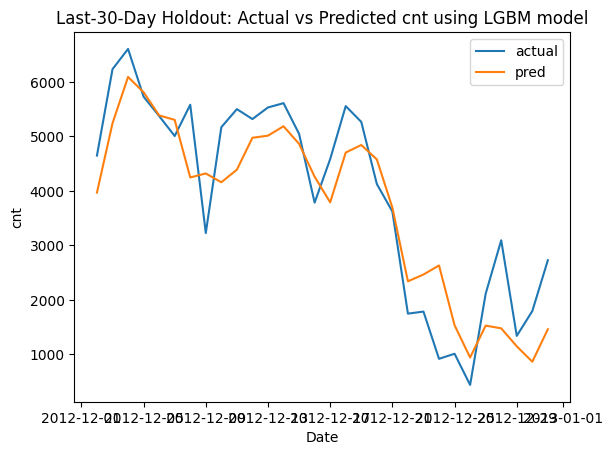

In [ ]:
# ---- features/target  ----
X_cols_day = get_feature_cols_ls(df_trainval_day)
y_col_day = 'cnt'

numeric_features_day = df_trainval_day[X_cols_day].select_dtypes(include=[np.number]).columns.tolist()
categorical_features_day = [c for c in df_trainval_day[X_cols_day].columns if c not in numeric_features_day]

preprocess = ColumnTransformer([
    ('num', StandardScaler(), numeric_features_day),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_day)
])

# ---- XGBoost pipeline, CV, fit, predict ----
xgb_model_day = XGBRegressor(
    random_state=42,
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='reg:squarederror',
    tree_method='hist'
)

pipe = Pipeline([('prep', preprocess), ('model', xgb_model_day)])

tscv = TimeSeriesSplit(n_splits=2)
scores = cross_val_score(
    pipe,
    df_trainval_day[X_cols_day], df_trainval_day[y_col_day],
    scoring='neg_root_mean_squared_error',
    cv=tscv
)
print('xgb_day CV RMSE:', np.round(-scores, 2))

pipe.fit(df_trainval_day[X_cols_day], df_trainval_day[y_col_day])
y_hat = pipe.predict(df_test_day[X_cols_day])
y_true = df_test_day[y_col_day].values

rmse = mean_squared_error(y_true, y_hat)
mae  = mean_absolute_error(y_true, y_hat)
r2   = r2_score(y_true, y_hat)
mape = np.mean(np.abs((y_true - y_hat) / np.maximum(1, np.abs(y_true)))) * 100.0
print(f'Test RMSE: {rmse:.2f}  MAE: {mae:.2f}  R^2: {r2:.3f}  MAPE*: {mape:.2f}%')


# ----- Plot -----
res = df_test_day[['dteday', 'cnt']].copy()
res['pred'] = y_hat

plt.figure()
plt.plot(res['dteday'], res['cnt'], label='actual')
plt.plot(res['dteday'], res['pred'], label='pred')
plt.title('Last-30-Day Holdout: Actual vs Predicted cnt using LGBM model')
plt.xlabel('Date')
plt.ylabel('cnt')
plt.legend()
plt.show()


**XGBoost model achieved a smaller RMSE on the test data compared to the linear (Ridge) model**, confirming that tree-based methods captured nonlinear relationships and interactions more effectively.  

## Part 4 - Reflection / comments

**Tasks:**
(Optional) Please share with us any free form reflection, comments or feedback you have in the context of this test task.

I really enjoyed working on this task — it provided a solid, hands-on opportunity to design a complete predictive pipeline from feature engineering and exploratory analysis to model training, validation, and evaluation. I particularly appreciated how it required end-to-end thinking: ensuring data quality, building robust time-aware splits, comparing model types, and interpreting results in an operational context.

## Submission

Please submit this notebook with your developments in .ipynb and .html formats as well as your requirements.txt file.

## References

[1] Lichman, M. (2013). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.